# 4th go:
- construct basis from Gaussian + derivatives
- fit time-series of CCFs in that way
- look at time-dependence of coefficients

Suzanne Aigrain @ Oxford, June 2019

In [67]:
%pylab inline
import pickle
from scipy.optimize import minimize
from scipy.interpolate import interp1d

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Read in solar data

In [68]:
years = ['2015','2017','2018']
for i, year in enumerate(years):
    with open('ccf_'+year,'rb') as infile:
        ccfYear = pickle.load(infile)
    if i == 0:
        nobs,nvel = np.shape(ccfYear)
    else:
        nobs += np.shape(ccfYear)[0]
crval1 = -20
cdelt1 = 0.25
x = np.arange(nvel) * cdelt1 + crval1
y = np.zeros((nobs,nvel))
bjd = np.zeros(nobs)
rvh = np.zeros(nobs)
bsrv = np.zeros(nobs)
ii = 0
for year in years:
    with open('ccf_'+year,'rb') as infile:
        ccfYear = pickle.load(infile)
    no = np.shape(ccfYear)[0]
    y[ii:ii+no,:] = 1.0 - ccfYear
    with open('vel_'+year,'rb') as infile:
        velYear = pickle.load(infile)
    bjd[ii:ii+no] = velYear[:,0]
    rvh[ii:ii+no] = velYear[:,1]
    bsrv[ii:ii+no] = velYear[:,2]
    ii += no
rvb = rvh - bsrv

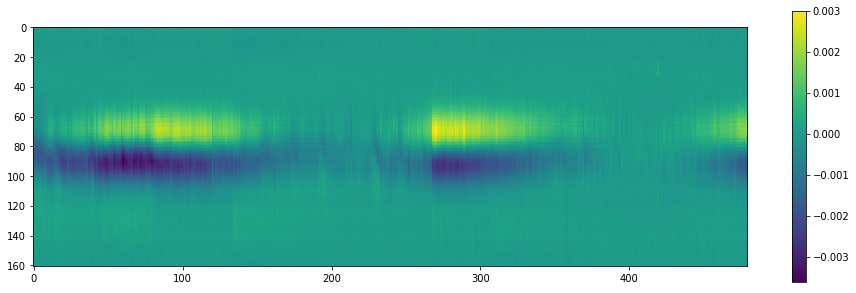

In [69]:
iref = 401
yref = y[iref,:]
plt.figure(figsize=(16,5))
plt.imshow((y-yref).T)
plt.colorbar()

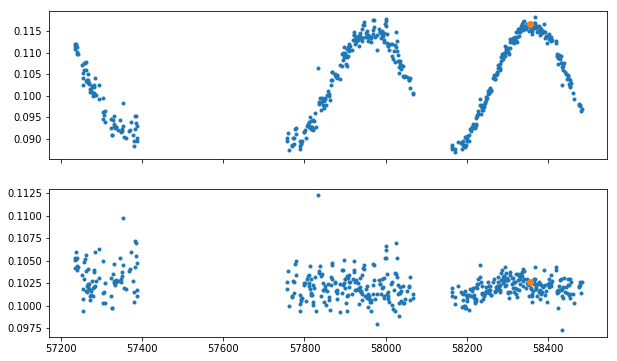

In [70]:
fig,axes=plt.subplots(2,1,sharex=True,figsize=(10,6))
axes[0].plot(bjd,rvb,'.')
axes[0].plot(bjd[iref],rvb[iref],'o')
axes[1].plot(bjd,rvh,'.')
axes[1].plot(bjd[iref],rvh[iref],'o')


### Construct basis

start by fitting reference CCF with Gaussian

[0.45 0.   3.5 ]
[0.46029098 0.11628768 2.94948479]


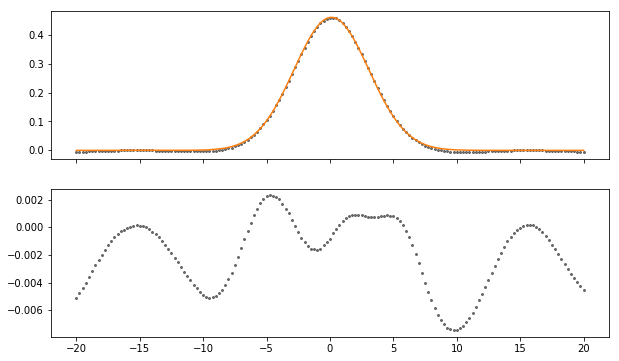

In [127]:
def CCFGauss(p,x):
    return p[0] * exp(-(x-p[1])**2/2.0/p[2]**2)
def nllG(p,x,y):
    r = y - CCFGauss(p,x)
    return (r**2).sum()
p0 = np.array([0.45,0.0,3.5])
print(p0)
soln = minimize(nllG,p0,args=(x,yref))
p1 = soln.x
print(p1)
g = CCFGauss(p1,x)
r = yref - g
fig,axes = plt.subplots(2,1,figsize=(10,6),sharex = True)
axes[0].plot(x,yref, 'k.', ms = 4, alpha = 0.5)
axes[0].plot(x,g,'C1')
axes[1].plot(x,r, 'k.', ms = 4, alpha = 0.5)


Now construct basis

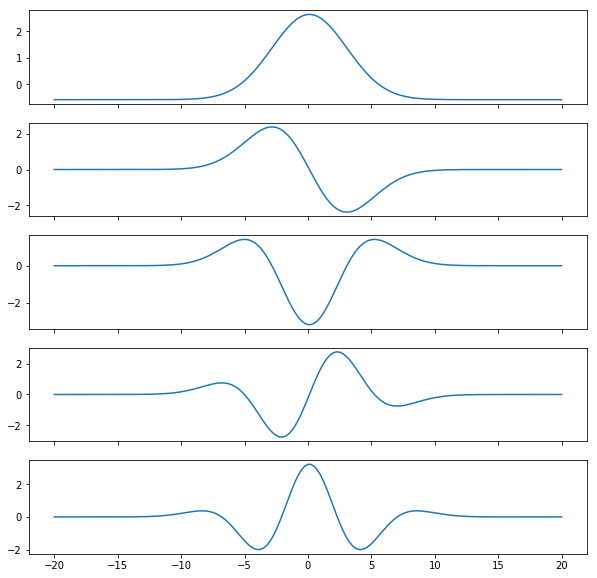

In [128]:
nder = 4
nb = 1 + nder
basis1 = np.zeros((nb+1,nvel))
g = CCFGauss(p1,x)
gmean, gstd = g.mean(), g.std()
basis1[0,:] = (g - gmean) / gstd
dx = x[1] - x[0]
xder = x[:-1] + 0.5 * dx
for ider in range(nder):
    der = (g[1:] - g[:-1])
    f = interp1d(xder,der,bounds_error=False,fill_value=0.0)
    g = f(x)
    gmean, gstd = g.mean(), g.std()
    basis1[ider+1,:] = (g - gmean) / gstd
basis1[-1,:]=1.0
fig,axes = plt.subplots(nb,1,sharex=True,figsize=(10,2*nb))
for ib in range(nb):
    axes[ib].plot(x,basis1[ib,:])    

[ 0.14407336  0.00069885 -0.00033305  0.000899   -0.00145939  0.08273643]


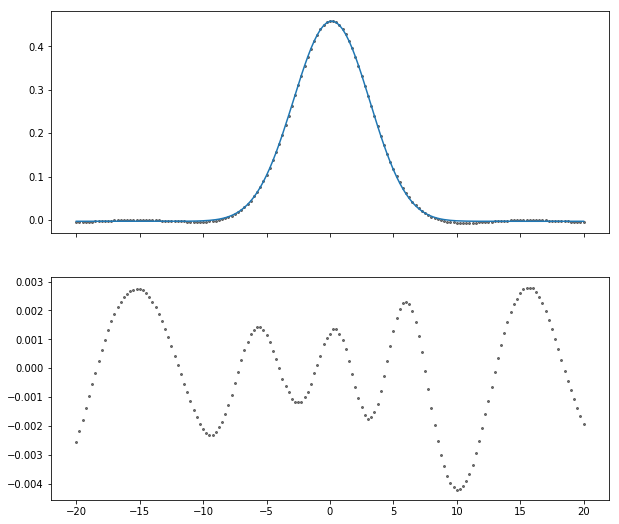

In [129]:
def nllBasis(p,basis,y):
    m = np.dot(p,basis)
    r = y - m
    return (r**2).sum() 
p0 = np.zeros(nb+1)
p0[0] = 1.0
soln = minimize(nllBasis,p0,args=(basis1,yref))
p1 = soln.x
print(p1)
m = np.dot(p1,basis1)
fig,axes = plt.subplots(2,1,figsize=(10,9),sharex = True)
axes[0].plot(x,yref, 'k.', ms = 4, alpha = 0.5)
axes[0].plot(x,m)
axes[1].plot(x,yref-m, 'k.', ms = 4, alpha = 0.5)

In [130]:
yfit1 = np.zeros_like(y)
coeffs1 = np.zeros((nobs,nb+1))
for iobs in range(nobs):
    soln = minimize(nllBasis,p1,args=(basis1,y[iobs,:]))
    yfit1[iobs,:] = np.dot(soln.x,basis1)
    coeffs1[iobs,:] = soln.x

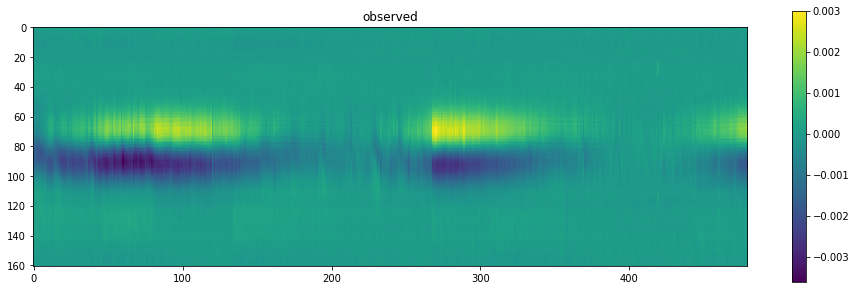

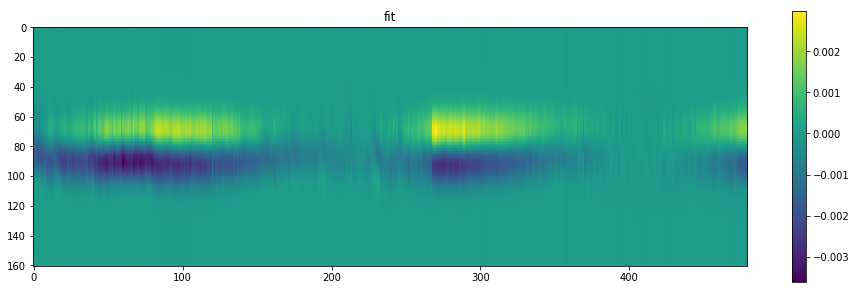

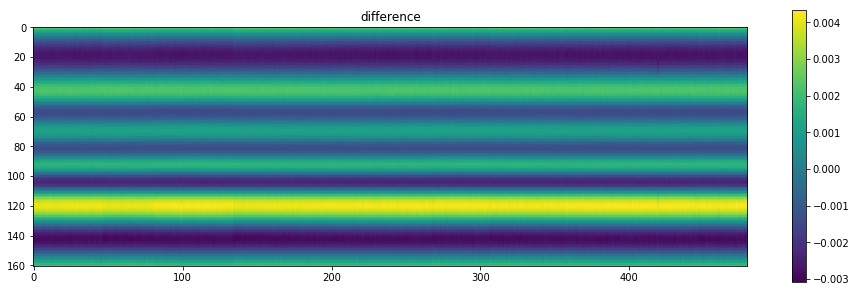

In [142]:
plt.figure(figsize=(16,5))
plt.title('observed')
plt.imshow((y-y[iref,:]).T)
plt.colorbar()

plt.figure(figsize=(16,5))
plt.title('fit')
plt.imshow((yfit1-yfit1[iref,:]).T)
plt.colorbar()

plt.figure(figsize=(16,5))
plt.title('difference')
plt.imshow((yfit1-y).T)
plt.colorbar()

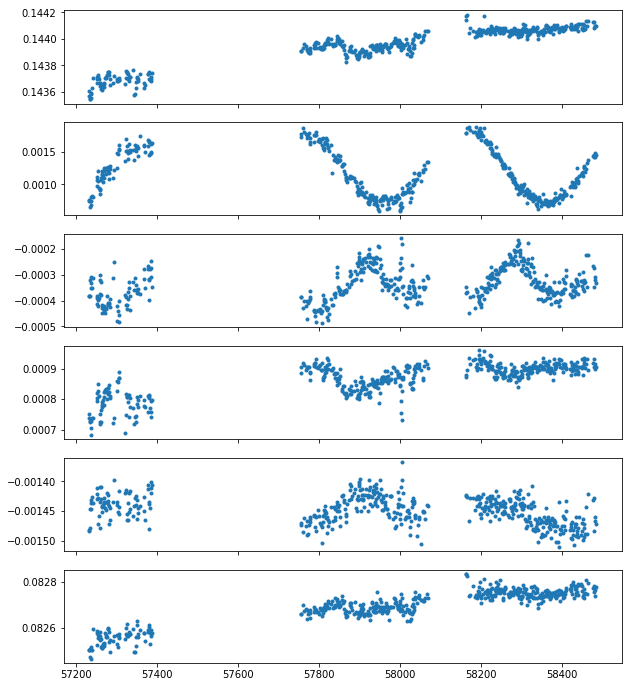

In [132]:
fig,axes = plt.subplots(nb+1,1,sharex=True,figsize=(10,2*(nb+1)))
for ib in range(nb+1):
    axes[ib].plot(bjd,coeffs1[:,ib],'.')    
    

### Try the same but using a GP fit to the reference CCF rather than a Gaussian

[  0.08269354 -13.81551056   0.           2.30258509]


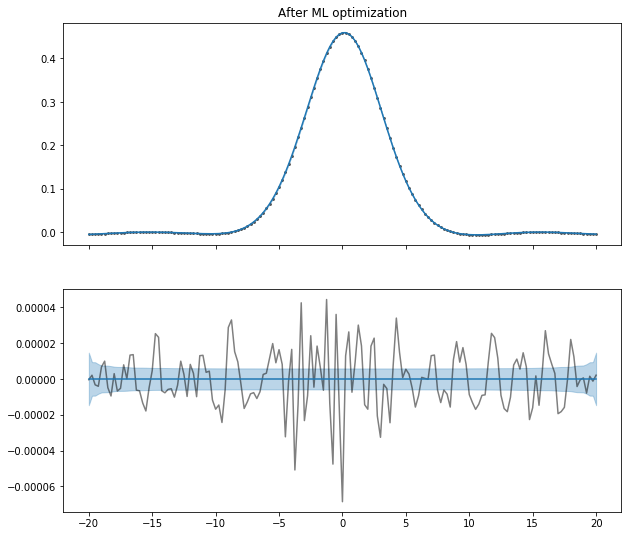

In [133]:
from george import kernels, GP
k = 1.0 * kernels.ExpSquaredKernel(10.0)
gp = GP(k,mean=np.mean(y), fit_mean=True, white_noise = np.log(1e-6), fit_white_noise=True)
print(gp.get_parameter_vector())
def nllGP(p,x,y):
    if (abs(p[2:])>10).any():
        return 1e25        
    gp.set_parameter_vector(p)
    try:
        gp.compute(x)
    except:
        return 1e25
    return -gp.lnlikelihood(y, quiet=True)
p0 = gp.get_parameter_vector()
soln = minimize(nllGP,p0,args=(x,yref))
p1 = soln.x
gp.set_parameter_vector(p1)
mu, var = gp.predict(yref, x, return_var=True)
std = np.sqrt(var)
fig,axes = plt.subplots(2,1,figsize=(10,9),sharex = True)
axes[0].set_title('After ML optimization')
axes[0].plot(x,yref, 'k.', ms = 4, alpha = 0.5)
axes[0].plot(x,mu)
axes[0].fill_between(x,mu+std,mu-std,alpha=0.3,color='C0')
axes[1].plot(x,yref-mu, 'k-', ms = 4, alpha = 0.5)
axes[1].plot(x,mu-mu)
axes[1].fill_between(x,std,-std,alpha=0.3,color='C0')

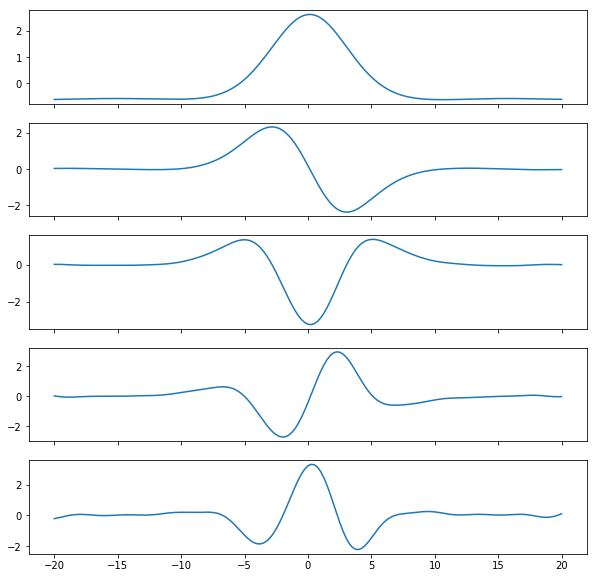

In [134]:
nder = 4
nb = 1 + nder
basis2 = np.zeros((nb+1,nvel))

newp = k.get_parameter_vector()
newp[1] = np.exp(newp[1])
gp.set_parameter('mean:value',0.0)
g = gp.predict(yref,x,return_var=False,return_cov=False)
gmean, gstd = g.mean(), g.std()
basis2[0,:] = (g - gmean) / gstd

kp = 1.0 * kernels.ExpSquaredPrimeKernel(10.0)
kp.set_parameter_vector(newp)
g = gp.predict(yref,x,kernel=kp,return_var=False,return_cov=False)
gmean, gstd = g.mean(), g.std()
basis2[1,:] = (g - gmean) / gstd

kp = 1.0 * kernels.ExpSquaredDoublePrimeKernel(10.0)
kp.set_parameter_vector(newp)
g = gp.predict(yref,x,kernel=kp,return_var=False,return_cov=False)
gmean, gstd = g.mean(), g.std()
basis2[2,:] = (g - gmean) / gstd

kp = 1.0 * kernels.ExpSquaredTriplePrimeKernel(10.0)
kp.set_parameter_vector(newp)
g = gp.predict(yref,x,kernel=kp,return_var=False,return_cov=False)
gmean, gstd = g.mean(), g.std()
basis2[3,:] = (g - gmean) / gstd

kp = 1.0 * kernels.ExpSquaredQuadruplePrimeKernel(10.0)
kp.set_parameter_vector(newp)
g = gp.predict(yref,x,kernel=kp,return_var=False,return_cov=False)
gmean, gstd = g.mean(), g.std()
basis2[4,:] = (g - gmean) / gstd

basis2[-1,:]=1.0

fig,axes = plt.subplots(nb,1,sharex=True,figsize=(10,2*nb))
for ib in range(nb):
    axes[ib].plot(x,basis2[ib,:])    

[ 1.43813583e-01 -2.33991919e-08  4.57175382e-07 -1.08816494e-08
  4.08149919e-07  8.27363961e-02]


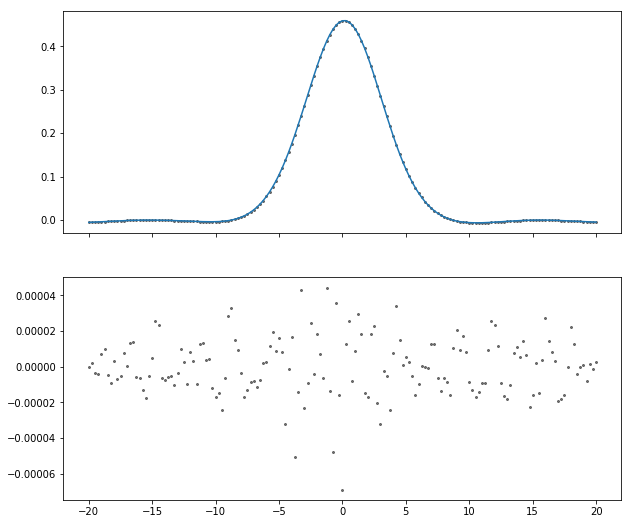

In [135]:
p0 = np.zeros(nb+1)
p0[0] = 1.0
soln = minimize(nllBasis,p0,args=(basis2,yref))
p1 = soln.x
print(p1)
m = np.dot(p1,basis2)
fig,axes = plt.subplots(2,1,figsize=(10,9),sharex = True)
axes[0].plot(x,yref, 'k.', ms = 4, alpha = 0.5)
axes[0].plot(x,m)
axes[1].plot(x,yref-m, 'k.', ms = 4, alpha = 0.5)

In [136]:
yfit2 = np.zeros_like(y)
coeffs2 = np.zeros((nobs,nb+1))
for iobs in range(nobs):
    soln = minimize(nllBasis,p1,args=(basis2,y[iobs,:]))
    yfit2[iobs,:] = np.dot(soln.x,basis2)
    coeffs2[iobs,:] = soln.x

Text(0.5, 0, 'vel (km/s)')

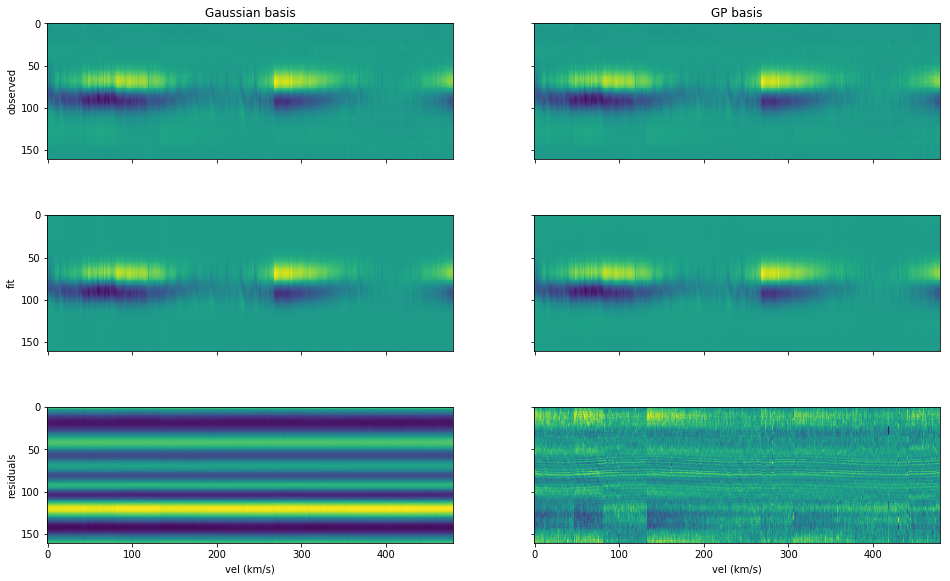

In [138]:
fig,axes=plt.subplots(3,2,figsize=(16,10),sharex=True,sharey=True)
axes[0,0].imshow((y-y[iref,:]).T)
axes[0,0].set_ylabel('observed')
axes[0,0].set_title('Gaussian basis')
axes[0,1].imshow((y-y[iref,:]).T)
axes[0,1].set_title('GP basis')
axes[1,0].imshow((yfit1-yfit1[iref,:]).T)
axes[1,0].set_ylabel('fit')
axes[1,1].imshow((yfit2-yfit2[iref,:]).T)
axes[2,0].imshow((yfit1-y).T)
axes[2,0].set_ylabel('residuals')
axes[2,0].set_xlabel('vel (km/s)')
axes[2,1].imshow((yfit2-y).T)
axes[2,1].set_xlabel('vel (km/s)')

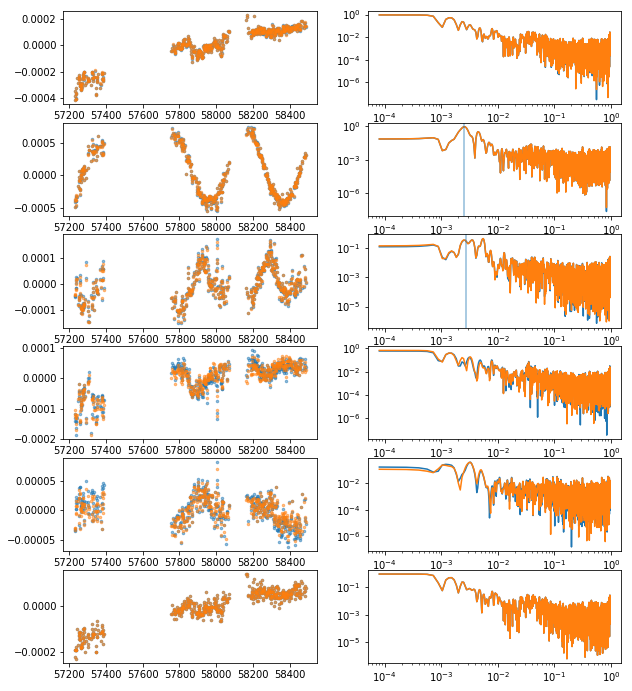

In [153]:
from astropy.stats import LombScargle
fig,axes = plt.subplots(nb+1,2,figsize=(10,2*(nb+1)))
for ib in range(nb+1):
    axes[ib,0].plot(bjd,coeffs1[:,ib]-np.mean(coeffs1[:,ib]),'C0.',ms=5,alpha=0.5)    
    axes[ib,0].plot(bjd,coeffs2[:,ib]-np.mean(coeffs2[:,ib]),'C1.',ms=5,alpha=0.5) 
    frequency, power = LombScargle(bjd, coeffs1[:,ib]).autopower()
    axes[ib,1].plot(frequency,power)
    frequency, power = LombScargle(bjd, coeffs2[:,ib]).autopower()
    axes[ib,1].plot(frequency,power)    
    axes[ib,1].loglog()
    if ib == 1:
        axes[ib,1].axvline(1/399.,alpha=0.5)
    if ib == 2:
        axes[ib,1].axvline(1/365.,alpha=0.5)    

At this stage I have to think about what to do next. Two options present themselves. 

One is to use the coefficients of the linear basis model as new activity indicators and incorporate them into a model similar to Vinesh's GP framework. I would probably need Oscar's help to implement it. 

The other option would be to analyse synthetic time-series of CCFs produced using SOAP2.0 and examine the behaviour of the coefficients of the different basis terms for spot, faculae, and Doppler shifts separately, in the hope that this might lead to new insights. I should probably do both!